In [241]:
import copy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch import nn
from sklearn.metrics import accuracy_score

In [242]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [243]:
from cassava.utils import *
from cassava.transforms import get_train_transforms, get_test_transforms

# Prepare data

In [244]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-09 19:15:26,355 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [245]:
train_labels = context.catalog.load('train_labels')

2020-12-09 19:15:26,377 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [246]:
parameters = context.catalog.load('parameters')

2020-12-09 19:15:26,402 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [247]:
parameters

{'seed': 42,
 'validation_size': 0.15,
 'gpus': -1,
 'data_loader_workers': 6,
 'batch_size': 10,
 'max_epochs': 100,
 'max_steps': 0,
 'auto_lr_find': 0,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'early_stop_patience': 4,
 'reduce_lr_on_pleteau_patience': 2,
 'save_top_k_checkpoints': 1,
 'checkpoints_dir': 'data/06_models/checkpoints',
 'cv_splits': 3,
 'cv_models_dir': 'data/06_models/cv_folds'}

In [248]:
res = context.pipelines['train'].nodes[0].run({'train_labels': train_labels, 'parameters': parameters})
train_indices = np.array(res['train_indices'])
val_indices = np.array(res['val_indices'])

2020-12-09 19:15:26,417 - kedro.pipeline.node - INFO - Running node: split: split_data([parameters,train_labels]) -> [train_indices,val_indices]


In [249]:
train_indices.shape, val_indices.shape

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((18187,), (3210,))

In [250]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [251]:
raw_transforms = A.Compose([
        A.ToFloat(max_value=1.0),
        A.Resize(32, 32),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
])

def get_train_transforms():
    return A.Compose([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=1),
        A.ToFloat(max_value=1.0),
        A.RandomResizedCrop(256, 256, scale=(0.3, 0.9)),
        A.Resize(32, 32),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


def get_test_transforms():
    return A.Compose([
        A.ToFloat(max_value=1.0),
        A.CenterCrop(400, 400),
        A.Resize(32, 32),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [252]:
train_transform, val_transform = get_train_transforms(), get_test_transforms()

train_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=train_indices),
                                      transform=train_transform)

val_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=val_indices),
                                transform=val_transform)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=parameters['batch_size'],
                                                num_workers=parameters['data_loader_workers'],
                                                shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset, num_workers=parameters['data_loader_workers'], batch_size=parameters['batch_size'])

In [253]:
raw_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=raw_transforms)
augmented_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_train_transforms())
test_aug_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_test_transforms())

3


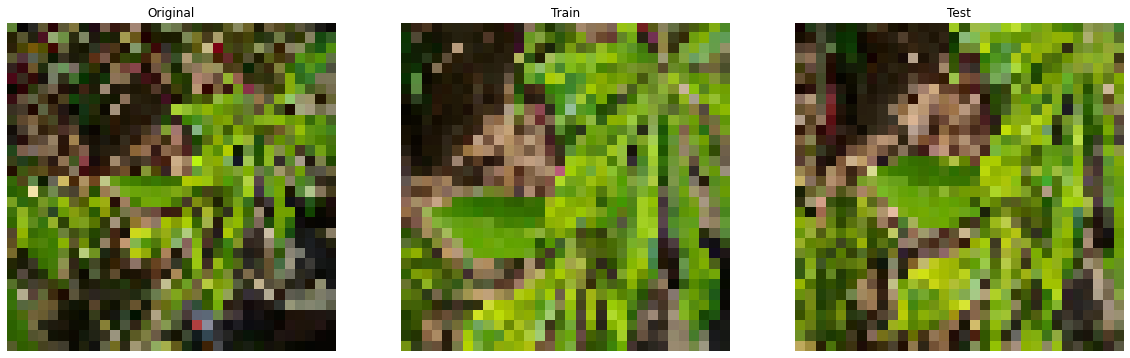

In [254]:
idx = np.random.choice(range(len(train_images_torch)))
raw_image, label = raw_dataset[idx]
aug_image, _ = augmented_dataset[idx]
test_aug_image, _ = test_aug_dataset[idx]

print(label)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plot_image(unnorm(raw_image))
plt.title('Original')
plt.subplot(1, 3, 2)
plot_image(unnorm(aug_image))
plt.title('Train')
plt.subplot(1, 3, 3)
plot_image(unnorm(test_aug_image))
plt.title('Test')
plt.show()

In [255]:
raw_image.shape, aug_image.shape, test_aug_image.shape

(torch.Size([3, 32, 32]), torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))

# Define model

In [256]:
#!pip install pytorch-lightning-bolts

In [257]:
from pl_bolts.models.autoencoders import VAE, AE

# Train

In [258]:
def plot_random_img_reconstruction(model):
    saved_transform = train_images_torch.transform
    
    train_images_torch.transform = None
    ds = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_test_transforms())

    random_idx = np.random.choice(range(len(train_images_torch)))
    image, label = ds[random_idx]
    image = image.to('cuda')
    model = model.to('cuda')
    
    train_images_torch.transform = saved_transform
    
    reconstruction = model(image.unsqueeze(0))[0].detach().cpu()
    reconstruction = torch.Tensor(reconstruction)
    
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plot_image(unnorm(image.to('cpu')), label=f"true: {label}")
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plot_image(unnorm(reconstruction))
    plt.title('Reconstructed')
    plt.show()
    

In [259]:
from pytorch_lightning import Trainer
from argparse import Namespace

In [308]:
class MyAE(AE):
    def on_epoch_start(self):
        plot_random_img_reconstruction(self)

In [309]:
# model2 = MyAE(input_height=96)
# model2.load_state_dict(model.state_dict())
# model = model2

In [310]:
model = MyAE(input_height=32)

In [320]:
parameters['auto_lr_find'] = True
parameters['limit_train_batches'] = 300
# parameters['lr'] = 0.1

In [321]:
hparams = Namespace(**parameters)

trainer = Trainer.from_argparse_args(
    hparams,
    reload_dataloaders_every_epoch = True,
)

GPU available: True, used: True


2020-12-09 19:28:36,329 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-09 19:28:36,330 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-09 19:28:36,331 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc      | Linear        | 131 K 


2020-12-09 19:28:36,545 - lightning - INFO - 
  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc      | Linear        | 131 K 


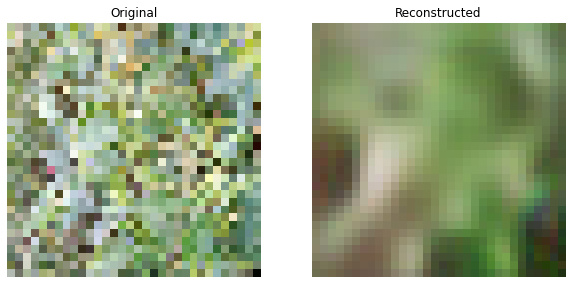

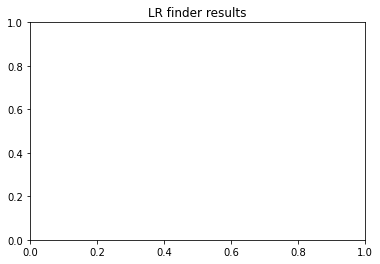

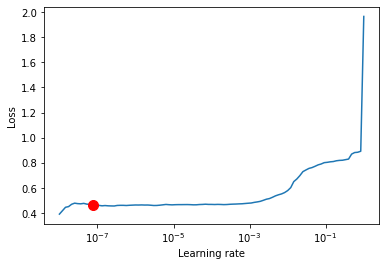

7.585775750291837e-08

In [322]:
lr_finder = trainer.tuner.lr_find(model,
                                  train_dataloader=train_data_loader,
                                  val_dataloaders=[val_data_loader])
plt.figure()
plt.title('LR finder results')
lr_finder.plot(suggest=True)
plt.show()
new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr
new_lr


  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc      | Linear        | 131 K 


2020-12-09 19:28:42,870 - lightning - INFO - 
  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc      | Linear        | 131 K 


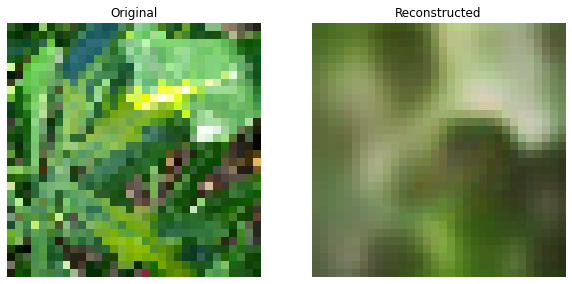

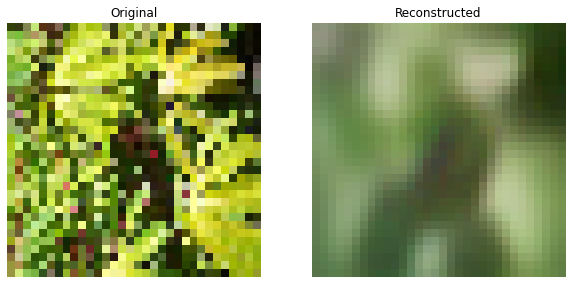

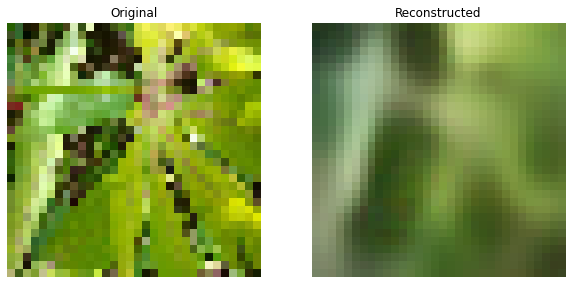

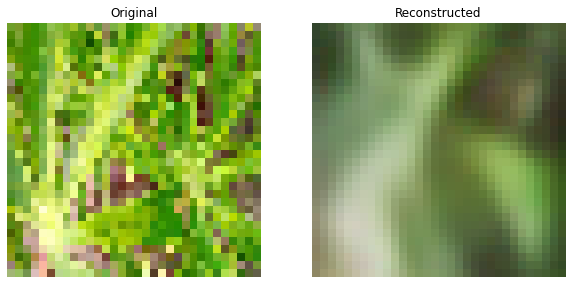

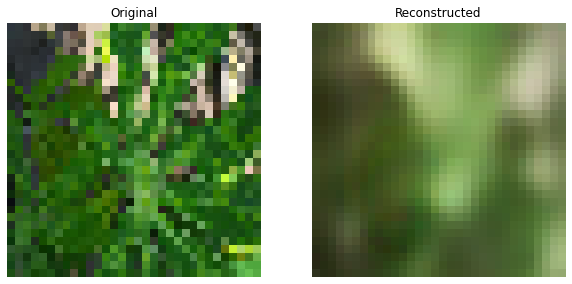

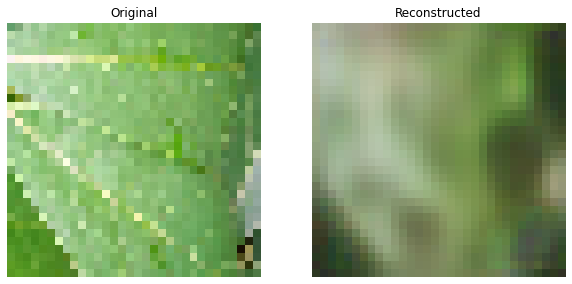

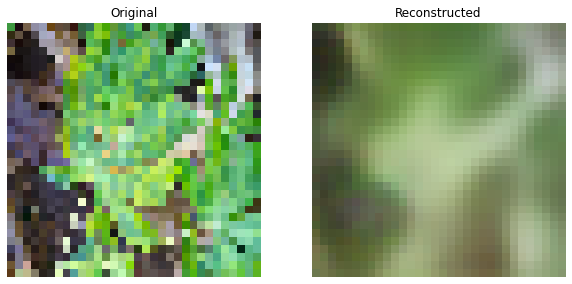

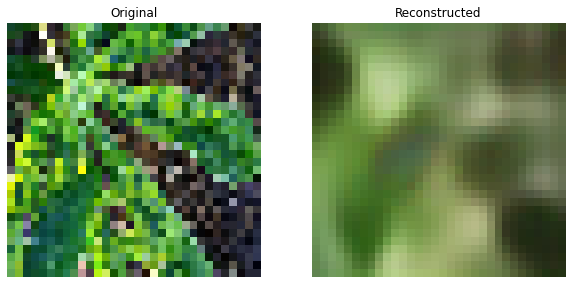

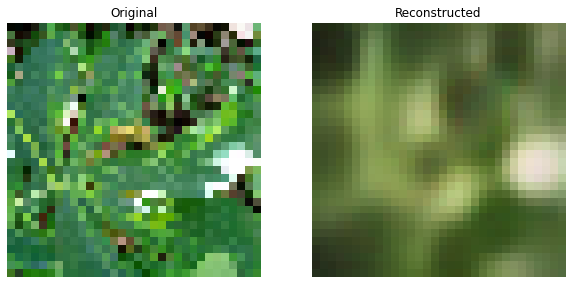

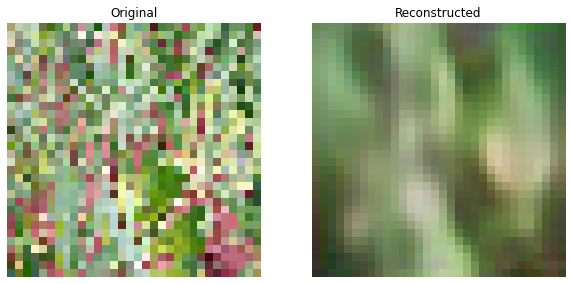

2020-12-09 19:32:43,540 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


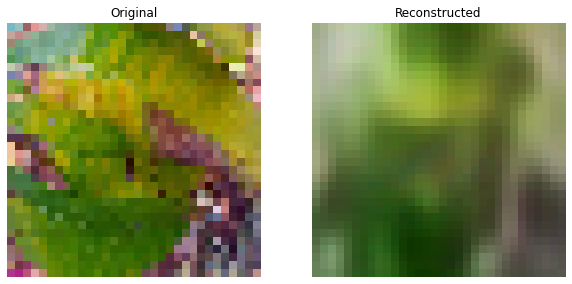

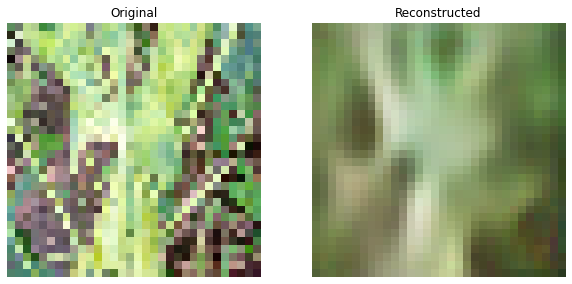

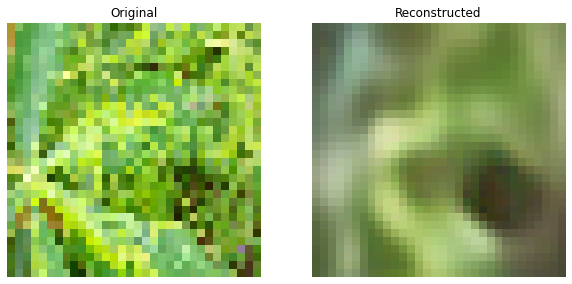

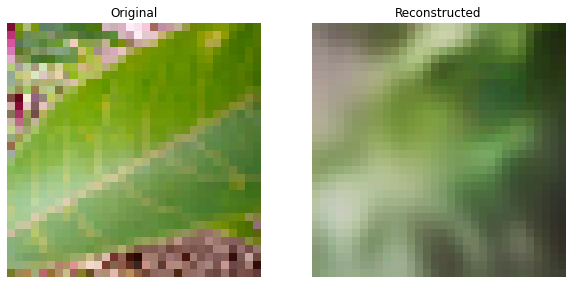

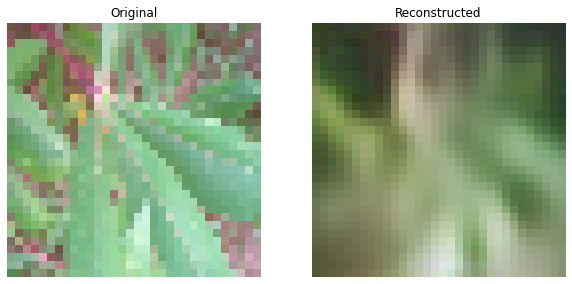

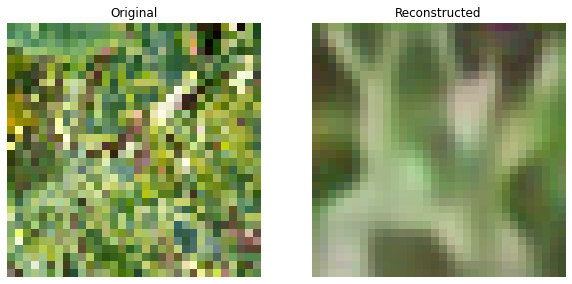

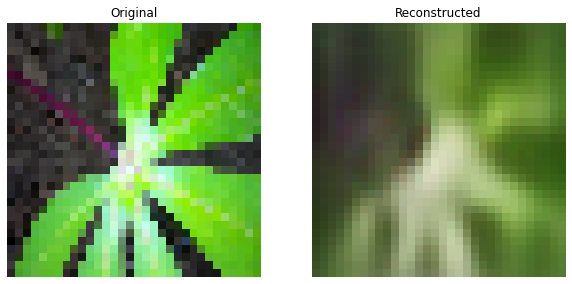

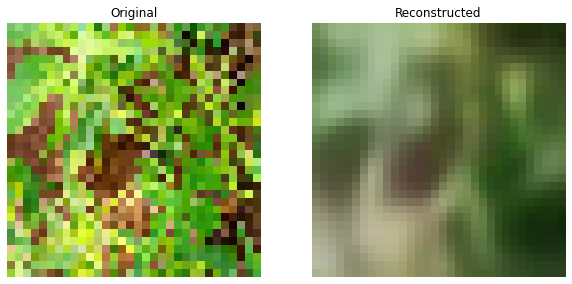

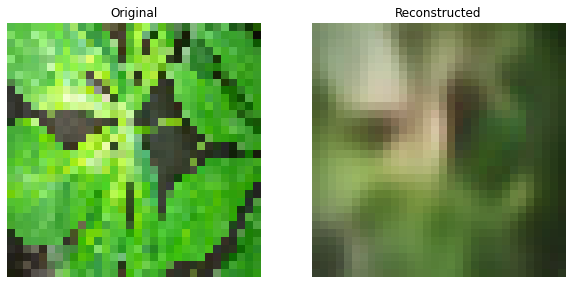

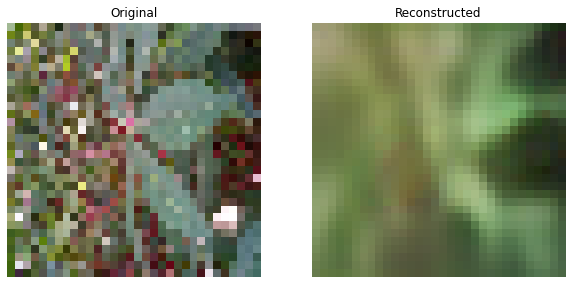

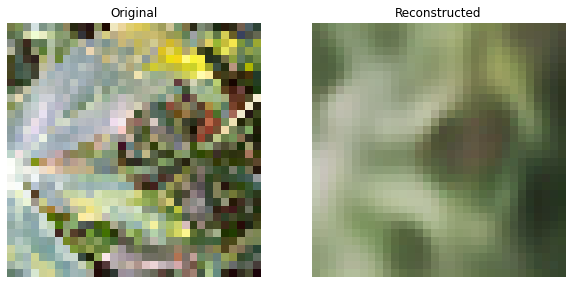

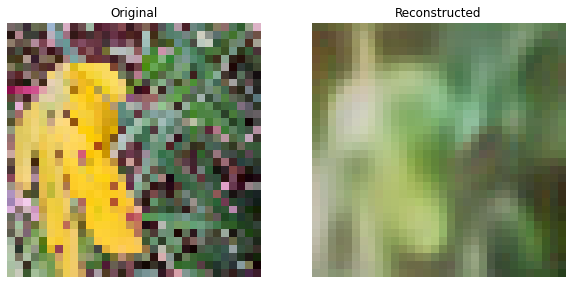

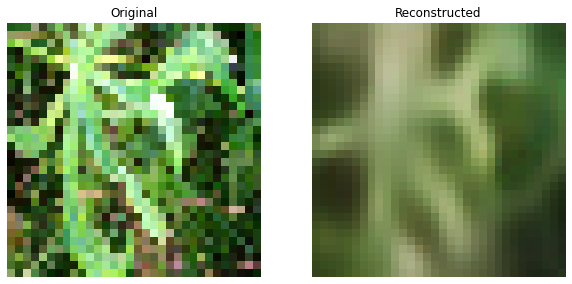

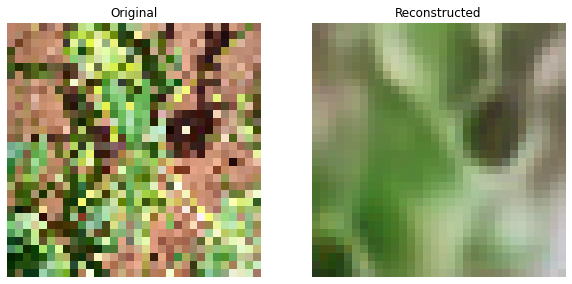

In [ ]:
trainer.fit(model, train_data_loader, val_data_loader)

In [315]:
model = model.eval()

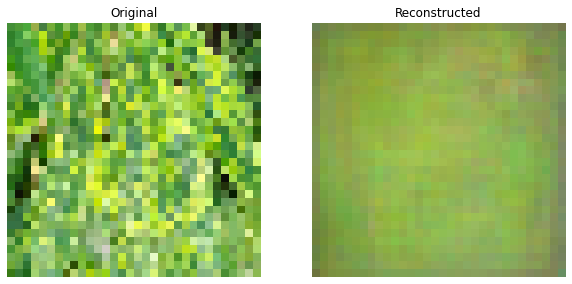

In [280]:
plot_random_img_reconstruction(model)